This Kaggle dataset has already been well explored via a number of Kaggle projects.  Rather than repeat their work, we're going to dive straight into the interesting parts.

## Train a model

Note: Training the image classification model can take a long time.  This code is included for demonstration purposes for how we trained the model - which ultimately gets serialized a number of different ways.  

However, you have the option of just copying the serialized files to the correct locations and running the **Results** section.

### Get the data

In [1]:
import numpy as np

import cv_model as cv
import tensorflow as tf

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


In [2]:
# get keras model
# the function preprocess_input is keras model dependent, so this is abstracted in a function so all the correct information can be produced at once
base_model, model_name, preprocess_input = cv.get_keras_model()

In [3]:

# label mapping maps the numerically encoded label e.g. 1 back to the label e.g.'butter_naan'
mapping_dct = cv.get_label_mapping()

# get the fully split data that has been processed by the model specific preprocess_input function
X_train, y_train, X_test, y_test, X_val, y_val, label_encoder = cv.get_split_data(preprocess_input)

### Train the model

In [ ]:
# get number of classes to use as training target
num_classes = len(mapping_dct.values())

# the tasty_model uses transfer learning on the keras model and adds some layers for our use case
tasty_model = cv.get_tasty_model(base_model, num_classes)

# set the optimizer, learning rate, loss, and target metrics
tasty_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# training params
batch_size = 32
epochs = 20
spe = len(X_train) // batch_size    
verbose = 1

# Augment the training data with a generaator.
# This improves performance with a small amount of data while reducing chance of overfitting due to the model not seeing the exact same image twice.
flow = cv.get_generator_flow(X_train, y_train, batch_size=batch_size)

# train
history = tasty_model.fit(flow, validation_data=(X_val, y_val), epochs=epochs, steps_per_epoch=spe, verbose=verbose)

# Evaluate model
val_loss, val_accuracy = tasty_model.evaluate(X_val, y_val)
print(f'Validation accuracy: {val_accuracy * 100:.2f}%')

Epoch 1/20
149/149 [==============================] - 569s 4s/step - loss: 3.0329 - accuracy: 0.4191 - val_loss: 2.3025 - val_accuracy: 0.6494
Epoch 2/20
149/149 [==============================] - 2801s 19s/step - loss: 2.3544 - accuracy: 0.5559 - val_loss: 1.8032 - val_accuracy: 0.7078
Epoch 3/20
149/149 [==============================] - 563s 4s/step - loss: 1.7923 - accuracy: 0.6183 - val_loss: 1.1475 - val_accuracy: 0.7579
Epoch 4/20
149/149 [==============================] - 555s 4s/step - loss: 1.4425 - accuracy: 0.6499 - val_loss: 1.1122 - val_accuracy: 0.7679
Epoch 5/20
149/149 [==============================] - 646s 4s/step - loss: 1.1804 - accuracy: 0.6781 - val_loss: 1.1029 - val_accuracy: 0.8013
Epoch 6/20
149/149 [==============================] - 561s 4s/step - loss: 1.1137 - accuracy: 0.6985 - val_loss: 1.0537 - val_accuracy: 0.7896
Epoch 7/20
149/149 [==============================] - 526s 4s/step - loss: 1.0487 - accuracy: 0.7094 - val_loss: 1.0963 - val_accuracy: 0.76

#### Visualize Training Progress

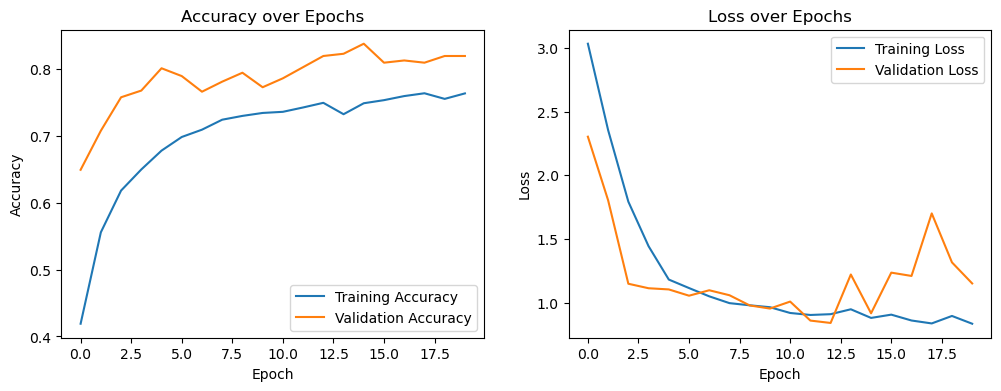

In [5]:
def plot_history(history):
    # Plotting training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()    
    
plot_history(history)

#### Persist trained model

In [ ]:
#keras_model_path = 'models/efficientnet_v2_20_84.64.keras' 
#tflite_path='models/lite/efficientnet_v2_20_84.64.tflite' 
#weights_path = 'models/weights/efficientnet_v2_20_84.64.hdf5' 

# fake paths for testing...  delete before submitting
keras_model_path = 'models/efficientnet_v2_20_84.64_test.keras'
tflite_path='models/lite/efficientnet_v2_20_84.64_test.tflite' 
weights_path = 'models/weights/efficientnet_v2_20_84.64_test.hdf5' 


Approach 1: Save whole model

In [12]:
# save full keras model
tasty_model.save(keras_model_path)

Approach 2: Save weights

In [13]:
# save model weights
tasty_model.save_weights(weights_path)

Approach 3: Convert to tflite and save that

In [14]:
# prepare converter
converter = tf.lite.TFLiteConverter.from_keras_model(tasty_model) 

# life saving option found on stackoverflow
# https://stackoverflow.com/questions/69888228/converting-a-keras-model-to-tensorflow-lite-how-to-avoid-unsupported-operation
converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
  tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]

# perform conversion
tflite_model = converter.convert()

# save
with open(tflite_path, 'wb') as f:     
  f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Jon\AppData\Local\Temp\tmpsh429nyo\assets


INFO:tensorflow:Assets written to: C:\Users\Jon\AppData\Local\Temp\tmpsh429nyo\assets


## Results

This section is independent of training and evaluates results against persisted models.

In [15]:
import numpy as np

import cv_model as cv
import cv_predict as cvp

import keras
import tensorflow as tf

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [16]:
# get keras model
# the function preprocess_input is keras model dependent, so this is abstracted in a function so all the correct information can be produced at once
preprocess_input = cv.get_keras_preprocessing()

# get data
X_train, y_train, X_test, y_test, X_val, y_val, label_encoder = cv.get_split_data(preprocess_input)

# get model
# we will only evalute against the tflite model as that's what we're going to use in the end
pred_model = cvp.TastyFoodPredictor(preprocess_input_fn=preprocess_input, use_keras=False, use_tflite=True)

Use **X_test** and **y_test** for model evaluation.  Since these datasets were not used during training, it should give us some insight into model generalizability.

In [17]:
# get predictions
y_pred = pred_model.predict_batch(X_test)
y_true = y_test

# since this is a multi-class target, use np.argmax to get the top choice for each row
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_true, axis=1)

#### Precision and Recall

In [18]:
from sklearn.metrics import classification_report
import pandas as pd

target_names  = label_encoder.inverse_transform(range(0,20))
target_names = [name.replace('_', ' ').title() for name in target_names]

The classification report will produce a score for each of the labels and also an overall accuracy, macro avg and weighted avg.  
We're going to separate these as we're mostly interested in how the individual labels performed.

In [19]:
report = classification_report(y_true_classes, y_pred_classes, target_names=target_names, output_dict=True)
df_all = pd.DataFrame(report).T

# all the names that are in the target names are the actual dish values
df_dishes = df_all[df_all.index.isin(target_names)]

# all the rows that aren't in the target names are the aggregated metrics
df_metric = df_all[~df_all.index.isin(target_names)]

# for funsies, let's look at the metrics
df_metric

,precision,recall,f1-score,support
accuracy,0.837793,0.837793,0.837793,0.837793
macro avg,0.841131,0.832624,0.834381,598.000000
weighted avg,0.840101,0.837793,0.836752,598.000000


Now let's sort the labels by f1-score and have a look at those

In [20]:
df_dishes = df_dishes.sort_values(by='f1-score', ascending=False)
df_dishes

,precision,recall,f1-score,support
Burger,1.000000,0.966667,0.983051,30.0
Jalebi,0.931034,0.931034,0.931034,29.0
Chai,0.871795,0.944444,0.906667,36.0
Pizza,0.793103,1.000000,0.884615,23.0
Dhokla,0.862069,0.892857,0.877193,28.0
Dal Makhani,0.896552,0.838710,0.866667,31.0
Fried Rice,0.815789,0.911765,0.861111,34.0
Idli,0.862069,0.833333,0.847458,30.0
Momos,0.818182,0.870968,0.843750,31.0
Kaathi Rolls,0.806452,0.862069,0.833333,29.0


We see that *Paani Puri* and *Butter Naan* had some of the lowest F1 scores.  Also note that *Paani Puri* had low support so this could be a not-enough-data  issue.

Let's look at a confusion matrix to see if any of the low F1 labels were commonly mistaken for something else. 

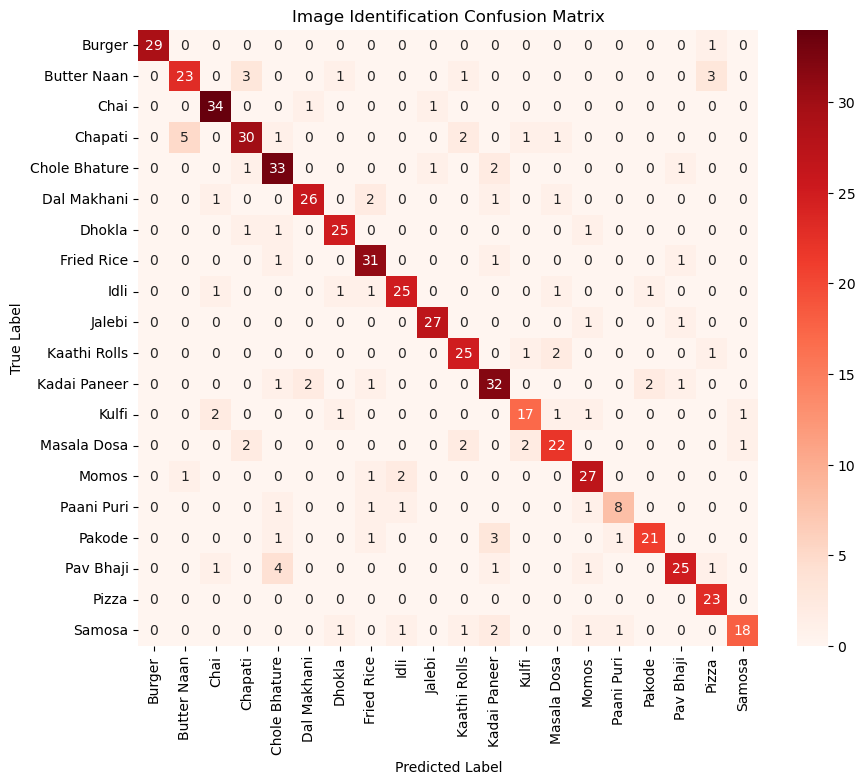

In [ ]:
# adapted from https://www.kaggle.com/code/varsha300/transferlearning but I added labels
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds',  xticklabels=target_names, yticklabels=target_names)
plt.title('Image Identification Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

Unsurprisingly, *Paani Puri*  was confused for many things, possibly due to lack of support.

*Butter Naan* (one of our other bottom F1 scorers) was commonly confused with two different dishes.  Let's look at the images to compare.

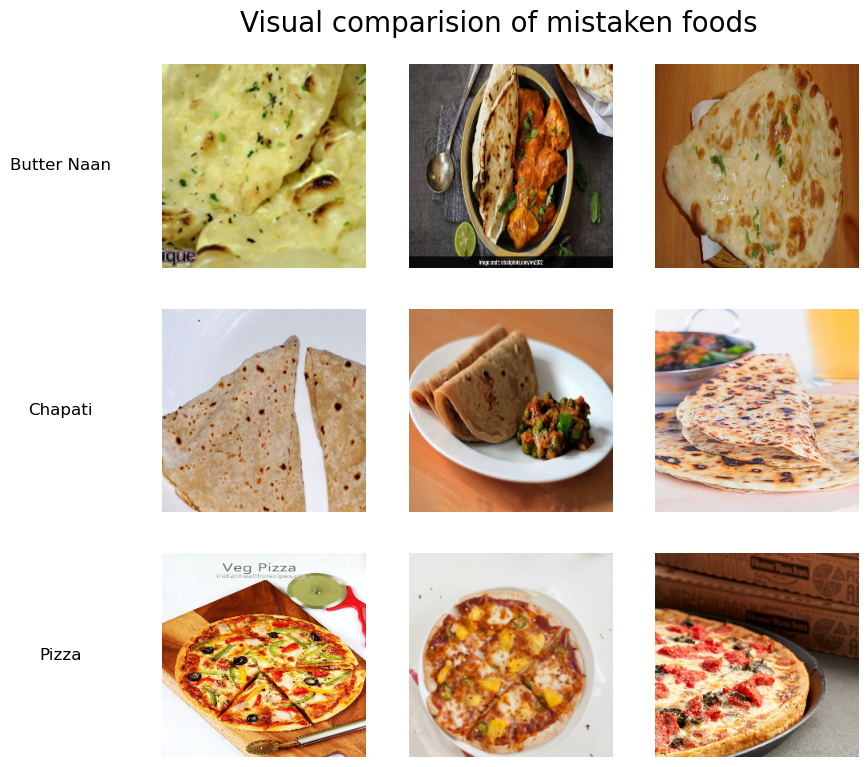

In [22]:
from os import listdir
import random
import cv2

def get_image_paths(food_name, num_images=3):
    path = f'data/Food_Classification/{food_name}/'
    files = listdir(path)
    return [f'{path}{file}' for file in random.choices(files, k=num_images)] 
    

def compare_images(base_food_name, comparison_food_list, num_images_per_food=3):

    def covert_to_pathname(name):
        return name.replace(' ', '_').lower()
    
    
    all_foods = [base_food_name] + comparison_food_list
    
    # Create subplots
    nrows = len(comparison_food_list) + 1
    fig, axes = plt.subplots(nrows=nrows, ncols=num_images_per_food, figsize=(9, 3*nrows))
    fig.suptitle('Visual comparision of mistaken foods', fontsize=20, y=0.94, verticalalignment="top")
    
    for i, food_name in enumerate(all_foods):
        
        food_folder = covert_to_pathname(food_name)
        food_image_paths = get_image_paths(food_folder, num_images_per_food)        
        
        for j, food_image_path in enumerate(food_image_paths):    
            image = cv2.cvtColor(cv2.imread(food_image_path), cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (255, 255))
            
            ax = axes[i, j]        
            ax.imshow(image)
            ax.axis('off')
            
            # only show title for first column
            if j==0:
                ax.text(-0.5, 0.5, food_name, transform=ax.transAxes, va='center', ha='center', fontsize=12)
    
    
compare_images('Butter Naan', ['Chapati','Pizza'])

Butter Naan, Chapati, and Pizza all look pretty similar.  To better differentiate between them, we'd probably want to train the model on a lot more images of each to help it get better at distinguishing between them.  We could also consider getting more data across the board to see if that helps improve the f1-scores.